In [8]:
# On importe la librairie bigml
from bigml.api import BigML
import time

In [2]:
# On se connecte à bigml
api = BigML(project='project/5d94a32e42129f2e16000232')

In [3]:
# On crée une source à partir du csv
source_train = api.create_source('storage/source_dataset_train_full.csv')
source_test = api.create_source('storage/source_dataset_test.csv')
api.ok(source_test)

True

In [9]:
# On crée un dataset à partir de la source puis on split (DATASET de TRAIN)
dataset_train_full = api.create_dataset(source_train, {"name": "Dataset Train Full"})
dataset_train_train = api.create_dataset(dataset_train_full, {"name": "Dataset Train Train", "sample_rate": 0.8, "seed": "my seed"})
api.ok(dataset_train_train)
dataset_train_test = api.create_dataset(dataset_train_full, {"name": "Dataset Train Test", "sample_rate": 0.8 , "seed": "my seed", "out_of_bag": True})
# On crée un dataset à partir de la source (DATASET de TEST)
dataset_test = api.create_dataset(source_test, {"name": "Dataset Test"})
api.ok(dataset_test)

You have reached the max number of parallel tasks
You'll need to buy some more credits to perform the chosen action


2019-11-04 08:53:00,444: You have reached the max number of parallel tasks
You'll need to buy some more credits to perform the chosen action


The resource couldn't be created: {'code': 402, 'status': {'code': -1108, 'message': 'You have reached the max number of parallel tasks'}}


2019-11-04 08:53:00,446: The resource couldn't be created: {'code': 402, 'status': {'code': -1108, 'message': 'You have reached the max number of parallel tasks'}}


In [10]:
# Learning Curves
graph_x = [] # Tous les x
graph_y_valset_ensemble = [] # AUC VAL SET / Ensemble
graph_y_valset_deepnet = [] # AUC VAL SET / Deepnet
graph_y_trainset_ensemble = [] # AUC TRAIN SET / Ensemble
graph_y_trainset_deepnet = [] # TRAIN SET / Deepnet

for i in range(1,11): # On boucle sur l'axe des abscisses / Taille du dataset de train / % de ligne du dataset de train_train
    # On crée le nouveau dataset de train à partir du dataset de train initial
    dataset_train_train_split = api.create_dataset(dataset_train_train, {"name": "Dataset Train Train " + str(i/10), "sample_rate": i/10, "seed": "my seed"})
    api.ok(dataset_train_train)    
    # On crée le modèle (ensemble) à partir du dataset split
    ensemble = api.create_ensemble(dataset_train_train_split, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble " + str(i/10)})
    api.ok(ensemble)
    
    # On crée le modèle (deepnet) à partir du dataset split
    deepnet = api.create_deepnet(dataset_train_train_split, {"objective_field" : "SeriousDlqin2yrs", "name": "Deepnet " + str(i/10)})
    api.ok(deepnet)
    
    ## VAL SET (évaluation sur le validation set)
    # On évalue le nouveau modèle (ensemble)
    evaluation_valset_ensemble = api.create_evaluation(ensemble, dataset_train_test)
    api.ok(evaluation_valset_ensemble)    
    # On évalue le nouveau modèle (deepnet)
    evaluation_valset_deepnet = api.create_evaluation(deepnet, dataset_train_test)
    api.ok(evaluation_valset_deepnet)
    
    ## TRAIN SET  (évaluation sur le train full)
    # On évalue le nouveau modèle (ensemble)
    evaluation_trainset_ensemble = api.create_evaluation(ensemble, dataset_train_train_split)
    api.ok(evaluation_trainset_ensemble)    
    # On évalue le nouveau modèle (deepnet)
    evaluation_trainset_deepnet = api.create_evaluation(deepnet, dataset_train_train_split)
    api.ok(evaluation_trainset_deepnet)
    
    # On stocke dans une liste la valeur de l'axe des abscisses (graph_x) et la valeur de l'AUC (graph_y) à partir de la donnée BigML
    graph_x.append(i*10)
    graph_y_valset_ensemble.append(evaluation_valset_ensemble['object']['result']['model']['average_area_under_roc_curve'])
    graph_y_valset_deepnet.append(evaluation_valset_deepnet['object']['result']['model']['average_area_under_roc_curve'])
    graph_y_trainset_ensemble.append(evaluation_trainset_ensemble['object']['result']['model']['average_area_under_roc_curve'])
    graph_y_trainset_deepnet.append(evaluation_trainset_deepnet['object']['result']['model']['average_area_under_roc_curve'])
    i += 1

print(f" > % of data {graph_x}")
print(f" > VAL SET / AUC Ensemble {graph_y_valset_ensemble}")
print(f" > VAL SET / AUC Deepnet {graph_y_valset_deepnet}")
print(f" > TRAIN SET / AUC Ensemble {graph_y_trainset_ensemble}")
print(f" > TRAIN SET / AUC Deepnet {graph_y_trainset_deepnet}")

 > % of data [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
 > VAL SET / AUC Ensemble [0.83455, 0.84738, 0.85052, 0.85144, 0.85358, 0.85511, 0.85356, 0.8552, 0.85526, 0.8556]
 > VAL SET / AUC Deepnet [0.83753, 0.84543, 0.84529, 0.83902, 0.84311, 0.83984, 0.83517, 0.84051, 0.84467, 0.84591]
 > TRAIN SET / AUC Ensemble [0.96708, 0.92917, 0.90885, 0.89863, 0.89383, 0.88989, 0.8854, 0.88273, 0.88117, 0.87901]
 > TRAIN SET / AUC Deepnet [0.88429, 0.87537, 0.86295, 0.85242, 0.85554, 0.85443, 0.84697, 0.85196, 0.84921, 0.85519]


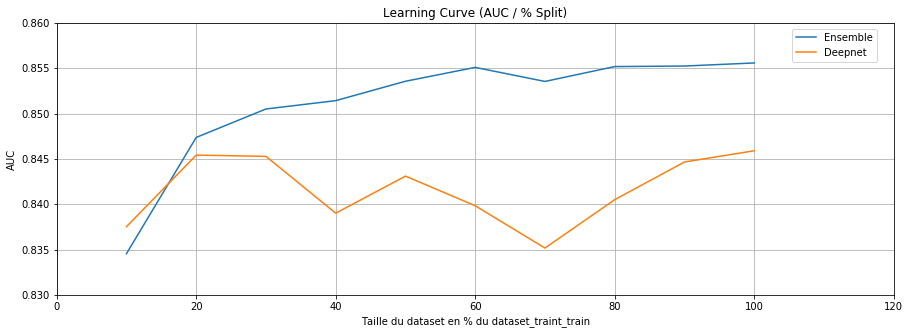

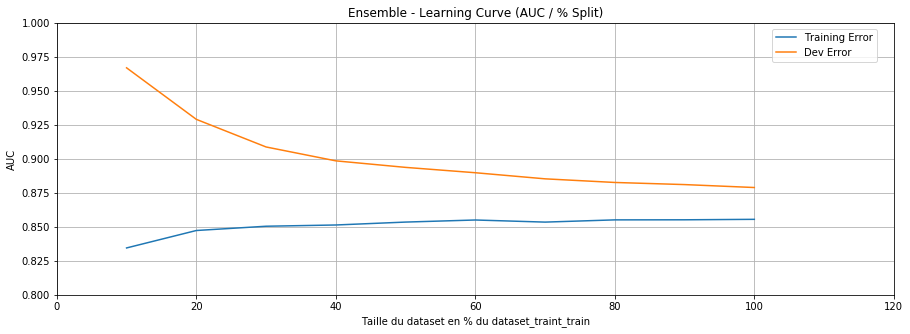

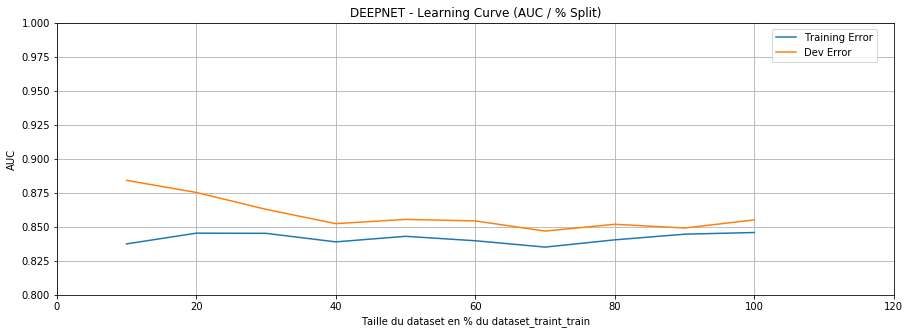

In [68]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(graph_x, graph_y_valset_ensemble, label='Ensemble')
ax.plot(graph_x, graph_y_valset_deepnet, label='Deepnet')
ax.set(xlim=(0, 120), ylim=(0.83, 0.86), xlabel='Taille du dataset en % du dataset_traint_train', ylabel='AUC',  title='Learning Curve (AUC / % Split)')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='best', borderaxespad=0.)
ax.grid()
plt.show()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(graph_x, graph_y_valset_ensemble, label='Training Error')
ax.plot(graph_x, graph_y_trainset_ensemble, label='Dev Error')
ax.set(xlim=(0, 120), ylim=(0.8, 1), xlabel='Taille du dataset en % du dataset_traint_train', ylabel='AUC',  title='Ensemble - Learning Curve (AUC / % Split)')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='best', borderaxespad=0.)
ax.grid()
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(graph_x, graph_y_valset_deepnet, label='Training Error')
ax.plot(graph_x, graph_y_trainset_deepnet, label='Dev Error')
ax.set(xlim=(0, 120), ylim=(0.8, 1), xlabel='Taille du dataset en % du dataset_traint_train', ylabel='AUC',  title='DEEPNET - Learning Curve (AUC / % Split)')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='best', borderaxespad=0.)
ax.grid()
plt.show()

In [12]:
api.pprint(dataset_train_train_split['object']['resource']) # Obtenir l'ID de la ressource

'dataset/5dbd3ba1e47684746800f857'


In [ ]:
# On lance un ensemble
ensemble = api.create_ensemble(dataset_train_train, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble"})
ensemble_full = api.create_ensemble(dataset_train_full, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble Full"})

In [ ]:
# On lance un batch sur le dataset TEST
batch_prediction = api.create_batch_prediction(ensemble_full, dataset_test, {"name": "Batch Prediction", "output_fields": ["Id"], "probabilities": True})
# On vérifie le bon fonctionnement du batch
api.ok(batch_prediction)

In [ ]:
# On lance un batch sur le dataset Train de validation
batch_prediction_all_fields = api.create_batch_prediction(ensemble, dataset_train_test, {"name": "Batch Prediction All Fields", "prediction_name" : "SeriousDlqin2yrs_Predic", "all_fields": True, "probabilities": True,})
# On vérifie le bon fonctionnement du batch
api.ok(batch_prediction_all_fields)

In [ ]:
# On récupère le ROC AUC via une évaluation
evaluation = api.create_evaluation(ensemble, dataset_train_test)
api.ok(evaluation)

In [ ]:
# On récupère le ROC AUC via une évaluation
evaluation_full = api.create_evaluation(ensemble_full, dataset_train_test)
api.ok(evaluation_full)

In [ ]:
# On affiche l'AUC depuis l'évaluation
#api.pprint(evaluation['object']['result'])
AUC = evaluation['object']['result']['model']['average_area_under_roc_curve']
print(f" AUC = {AUC}")

AUC = evaluation_full['object']['result']['model']['average_area_under_roc_curve']
print(f" AUC = {AUC}")

In [ ]:
# On télécharge les csv du batch et des datasets ainsi que le json de l'évaluation
api.download_batch_prediction(batch_prediction, filename='storage/batch_prediction.csv')
api.download_batch_prediction(batch_prediction_all_fields, filename='storage/batch_prediction_all_fields.csv')
api.download_dataset(dataset_train_full, filename='storage/dataset_train_full.csv')
api.download_dataset(dataset_train_train, filename='storage/dataset_train_train.csv')
api.download_dataset(dataset_train_test, filename='storage/dataset_train_test.csv')
api.download_dataset(dataset_test, filename='storage/dataset_test.csv')
api.export(evaluation, filename='storage/my_evaluation.json')